# Bootstrap CI notebook
This script expects that you have gathered all the \*bestlhood\* data from all the bootstrap directories
it's smart enough to figure out which is the best value per bootstrap replicate
just go to the output directory and do this:

`cat asymmigration-1463936*/*/*/boot*/*best* | grep 0 - > arremon.bootstrap.out`

(This will work because the migration rates always have a 0 in them.)

Then scp it to yeti (134.74.194.69)

In [1]:
from __future__ import print_function

from scipy import stats
import scikits.bootstrap as boot
import numpy as np
import scipy as sp
import math

MARTUM_BOOTDIR = "/Volumes/WorkDrive/MarTum-FSC/Results/bootstrap-results/bootstrap_out/"
MARTUM_OBSDIR = "/Volumes/WorkDrive/MarTum-FSC/Results/bootstrap-results/observed/"
species_list = ["arremon", "campylorhynchus", "melanopareia", "mimus", "saltator", "thamnophilus"]

In [2]:
col_headers = "ANCSIZE NPOP1   NPOP2   N1M1    N2M2    TDIV    MaxEstLhood     MaxObsLhood"
col_headers = col_headers.split()
print(col_headers)
print(len(col_headers))
print(species_list)

['ANCSIZE', 'NPOP1', 'NPOP2', 'N1M1', 'N2M2', 'TDIV', 'MaxEstLhood', 'MaxObsLhood']
8
['arremon', 'campylorhynchus', 'melanopareia', 'mimus', 'saltator', 'thamnophilus']


In [3]:
## Takes in the raw data and returns a dictionary of lists, one list for each
## parameter. It only returns the best lhood parameters for any given max_obslhood
def get_maxlhood_params(dat):
    max_stat_dict = {}
    for i in range(len(col_headers)):
        max_stat_dict[i] = []
    ## Get all the unique max obs lhoods
    for i in set(dat_t[-1]):
        curvals = [x for x in dat if x[-1] == i]
        maxlhood = max([x[-2] for x in curvals])
        maxlhood_vals = dat[np.where(dat[:,6] == maxlhood)]
        for j, k in enumerate(maxlhood_vals[0]):
            max_stat_dict[j].append(k)
    return max_stat_dict

# Run bootstrap CIs on just the maxlhood data

In [4]:
import pandas as pd
import numpy as np

stat_dict = {}
for i, d in enumerate(col_headers):
    df = pd.DataFrame(np.random.randn(6,4), index=species_list, columns=(["median", "lower", "upper", "mean"]))
    stat_dict[d] = df

def bootstrap_ci_maxlhood(max_stat_dict):

    for i, d in enumerate(col_headers):
        ## Dont do lhood cols
        if i > 5:
            continue
        n, min_max, mean, var, skew, kurt = stats.describe(max_stat_dict[i])
        std=math.sqrt(var)
        #print("\n"+d)
        #print("\n"+ d + "\tmin_max - {}\tmean - {}\tmedian - {}\t2std - {}".format(min_max, mean, np.median(max_stat_dict[i]), 1.96*std))
        print(d + "\tmedian - {}\tmean - {}".format(np.median(max_stat_dict[i]), mean), end="\t")
        #results = boot.ci(max_stat_dict[i],np.average,alpha=(0.05,0.95),n_samples=20000)
        #print("Bootstrapped CI w/ average - {}".format(results))
        results = boot.ci(max_stat_dict[i],np.mean,alpha=(0.05),n_samples=20000)
        print("CI - {}".format(results))
        #results = boot.ci(max_stat_dict[i],np.mean,alpha=(0.05),n_samples=20000)
        #print("Bootstrapped CI w/ mean - {}".format(results))

        ## Update statdict for this param and species
        stat_dict[d]["median"][species] = np.median(max_stat_dict[i])
        stat_dict[d]["lower"][species] = np.median(results[0])
        stat_dict[d]["upper"][species] = np.median(results[1])
        stat_dict[d]["mean"][species] = np.median(mean)


# Run bootstrap CIs on all data

In [62]:
def bootstrap_ci_all(dat_t):
    for i, d in enumerate(col_headers):
        if i > 5:
            continue
        n, min_max, mean, var, skew, kurt = stats.describe(dat_t[i])
        std=math.sqrt(var)
        print("min_max - {}\tmean - {}\tvar - {}\tstd - {}".format(min_max, mean, var, std))
        #print("min_max - {}\tmean - {}\tmedian - {}\t2std - {}".format(min_max, mean, np.median(dat_t[i]), 1.96*std))
        #print("Normal dist CI - {} - {}".format(d, stats.norm.interval(0.95, loc=mean, scale=std)))

        print(d + "\tmedian - {}\tmean - {}".format(np.median(dat_t[i]), mean), end="\t")
        #print("BCA")
        #results = boot.ci(dat_t[i],np.average,alpha=(0.05,0.95),n_samples=20000)
        #print("Bootstrapped CI w/ average - {}".format(results))
        try:
            results = boot.ci(dat_t[i],np.median,alpha=(0.05),n_samples=20000)
            print("CI - {}".format(results))
        except Exception as inst:
            print("Got exc {} - {}".format(d, inst))
        #results = boot.ci(dat_t[i],np.mean,alpha=(0.05),n_samples=20000)
        #print("Bootstrapped CI w/ mean - {}".format(results))

## Effectively the same
#    print("pi")
#    results = boot.ci(dat_t[i],np.average,alpha=(0.05,0.95),method='pi',n_samples=20000)
#    print("Bootstrapped CI w/ average - {}".format(results))
#    results = boot.ci(dat_t[i],np.median,alpha=(0.05),method='pi',n_samples=20000)
#    print("Bootstrapped CI w/ median - {}".format(results))
#    results = boot.ci(dat_t[i],np.mean,alpha=(0.05),method='pi',n_samples=20000)
#    print("Bootstrapped CI w/ mean - {}".format(results))
#    print("abc")
#    results = boot.ci(dat_t[i],np.average,alpha=(0.05,0.95),method='abc',n_samples=20000)
#    print("Bootstrapped CI w/ average - {}".format(results))
#    results = boot.ci(dat_t[i],np.median,alpha=(0.05),method='abc',n_samples=20000)
#    print("Bootstrapped CI w/ median - {}".format(results))
#    results = boot.ci(dat_t[i],np.mean,alpha=(0.05),method='abc',n_samples=20000)
#    print("Bootstrapped CI w/ mean - {}".format(results))

# Actually do the work and call the bootstrap functions

In [5]:
#for species in ["mimus"]:
for species in species_list:
    print("Doing {} - MaxLhood Only".format(species))
    bf = MARTUM_BOOTDIR + species + ".bootstrap.out"
    dat = np.loadtxt(bf, skiprows=0)
    dat_t = np.transpose(dat)
    ## Get a dict of all the maxlhood values for each param
    max_stat_dict = get_maxlhood_params(dat)
    bootstrap_ci_maxlhood(max_stat_dict)

for i in stat_dict.keys():
    print(i)
    print(stat_dict[i], "\n")
#for species in species_list:
#    print("Doing {} - Best of all lhoods (not normally advisable)".format(species))
#    bootstrap_ci_all(dat_t)

Doing arremon - MaxLhood Only
ANCSIZE	median - 790037.0	mean - 787360.06	CI - [ 729455.58  839600.58]
NPOP1	median - 65232.5	mean - 71829.28	CI - [ 67463.94  79626.12]
NPOP2	median - 357631.0	mean - 391586.9	CI - [ 369254.    429271.92]
N1M1	median - 0.0252829	mean - 0.025683162	CI - [ 0.02461684  0.02672976]
N2M2	median - 0.40996765	mean - 0.403309632	CI - [ 0.39224439  0.41463494]
TDIV	median - 1003058.0	mean - 1320173.52	CI - [ 1106677.14  1628982.08]
Doing campylorhynchus - MaxLhood Only
ANCSIZE	median - 144662.0	mean - 242728.767442	CI - [ 186985.65116279  315559.8372093 ]
NPOP1	median - 57351.0	mean - 57407.3023256	CI - [ 56570.95348837  58131.93023256]
NPOP2	median - 949314.0	mean - 930436.488372	CI - [ 902364.25581395  957206.04651163]
N1M1	median - 0.009218	mean - 0.00976803023256	CI - [ 0.00925428  0.01039719]
N2M2	median - 0.7160012	mean - 0.695701413953	CI - [ 0.66905288  0.72168587]
TDIV	median - 1402928.0	mean - 1397631.90698	CI - [ 1279229.58139535  1504202.93023256]
Doi

In [29]:
## Don't Use
## Get stats for transposed full dataset (this includes all the values
## even from the not maxlhood run)
for i, d in enumerate(col_headers):
    n, min_max, mean, var, skew, kurt = stats.describe(dat_t[i])
    std=math.sqrt(var)
    print("\n"+d)
    print("median - {}\taverage - {}".format(np.median(dat_t[i]), np.average(dat_t[i])))
    print("min_max - {}\tmean - {}\tvar - {}\tstd - {}".format(min_max, mean, var, std))
    print("CI - {} - {}".format(d, stats.norm.interval(0.95, loc=mean, scale=std)))
## Don't use


NA1
median - 49823.0	average - 50481.0588235
min_max - (13262.0, 94694.0)	mean - 50481.0588235	var - 407434016.437	std - 20184.9948337
NA1 - (10919.195921327089, 90042.921725731736)

NCL
median - 11612.0	average - 24263.1411765
min_max - (258.0, 116944.0)	mean - 24263.1411765	var - 917149660.432	std - 30284.4788701
NCL - (-35093.346699446964, 83619.629052388133)

NLN
median - 5757.0	average - 12021.5058824
min_max - (146.0, 56967.0)	mean - 12021.5058824	var - 219024123.967	std - 14799.4636378
NLN - (-16984.909838289059, 41027.921602994938)

M1
median - 0.00017086	average - 0.000755687007059
min_max - (1.64779e-05, 0.0080523000000000001)	mean - 0.000755687007059	var - 1.68828324243e-06	std - 0.00129933954086
M1 - (-0.0017909716967097248, 0.0033023457108273722)

M2
median - 0.0060471	average - 0.00631590956118
min_max - (4.29127e-05, 0.023994600000000001)	mean - 0.00631590956118	var - 1.34492495143e-05	std - 0.00366732184493
M2 - (-0.00087190917459353551, 0.013503728296946474)

TD2
medi

In [48]:
dat_t

array([[  5.42781000e+05,   6.89336000e+05,   5.50938000e+05,
          4.47229000e+05,   3.46092000e+05,   4.98385000e+05,
          7.80638000e+05,   6.08497000e+05,   1.75185000e+05,
          7.36507000e+05,   7.43762000e+05,   6.23463000e+05,
          7.10471000e+05,   5.51595000e+05,   1.74294000e+05,
          6.96588000e+05,   6.57502000e+05,   5.19744000e+05,
          2.36590000e+05,   3.62284000e+05,   1.06256400e+06,
          7.84561000e+05,   2.94180000e+05,   6.20077000e+05,
          5.51519000e+05,   2.36679000e+05,   1.07563300e+06,
          8.60376000e+05,   4.03196000e+05,   5.09891000e+05,
          5.44312000e+05,   7.71034000e+05,   7.33243000e+05,
          4.23039000e+05,   2.64663000e+05,   7.08516000e+05,
          9.38475000e+05,   4.66190000e+05,   1.91437000e+05,
          5.49909000e+05,   5.63989000e+05,   6.79735000e+05,
          6.85767000e+05,   7.65522000e+05,   7.54599000e+05,
          8.38591000e+05,   3.08353000e+05,   5.52474000e+05,
        

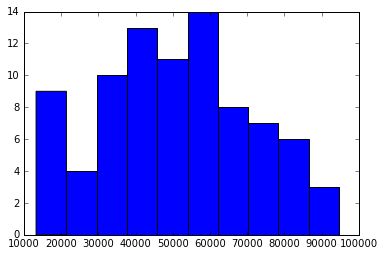

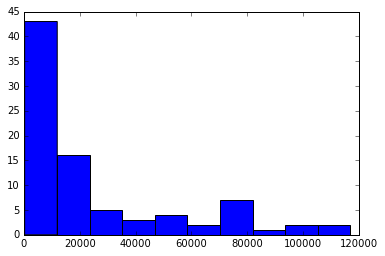

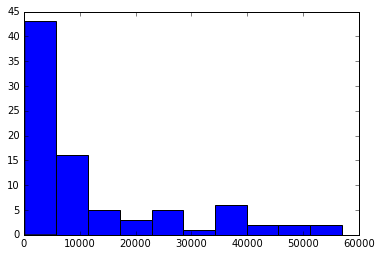

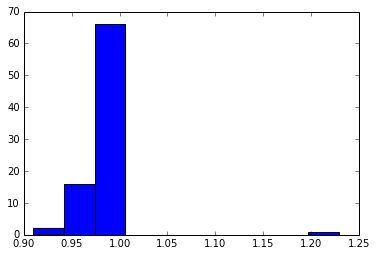

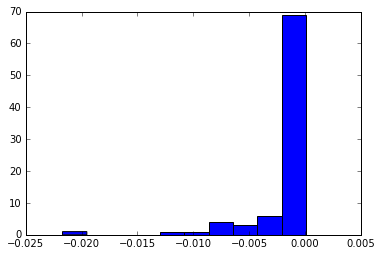

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py
for i,j in enumerate(col_headers):
    if "N" in j:
        plt.hist(dat_t[i])
        plt.show()

In [20]:
a = dat
a[np.where(a[:,12] == maxlhood)]

array([[  6.71250000e+04,   9.79760000e+04,   4.66370000e+04,
          2.11884000e-05,   2.27530000e-03,   7.69200000e+04,
          9.72994700e-01,   7.11986000e-01,   5.47650000e+04,
          5.32860000e+04,  -9.15294000e-06,   1.88174000e-06,
         -1.06181040e+04,  -1.02376360e+04]])

In [40]:
wat = stat_dict["NPOP1"]
wat.loc("arremon","mean")
wat["mean"]["arremon"]

10.0